# Data Project: The fishing industry in Denmark
**Introduction to Programming and Numerical Analysis**

<img src='tegning_torsk.jpg' alt='insertionsort' width=30% />

This project explores select data on the fishing industry in Denmark from Statistics Denmark (Danmarks Statistik), https://www.dst.dk/en.

Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

import pandas_datareader # A wrapper for multiple APIs with a pandas interface install with `pip install pandas-datareader`
from dstapi import DstApi # The DST API wrapper - install with `pip install git+https://github.com/alemartinello/dstapi`

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams.update({'axes.grid':False,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 12, 'axes.titlepad':10.0})
%matplotlib inline

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# import custom modules
from dataproject import *


## Read and clean data

Data is fetched from Statistics Denmark using their API. The Python package used to communicate with this interface is `dstapi`.

The following tables are downloaded:

* **FISK1**: Danish vessels by region, unit, type of vessels, length and tonnage
* **FISK2**: Landings by Danish vessels by region, harbour, unit and type of fish
* **SKIB95**: Accidents at sea involving danish vessels by type of accident, type of vessel and scope
* **MRU1**: Air Emission Accounts by industry and type of emission

In [2]:
table_names = ['FISK1', 'FISK2', 'SKIB95', 'MRU1'] # list of tables from Statistikbanken that are to be fetched

API_objects = {} # empty dictionary to store API objects

# for each table in table_names, call the DstApi
for i in table_names:
    table = DstApi(i)
    API_objects[i] = table

# for each variable, create a variable with the table name as the variable name
for i, table in API_objects.items():
    exec(f'{i}_api = table')

### Landings by Danish vessels (FISK2:)

First, we begin with inspecting the table FISK2.

In [3]:
tabsum = FISK2_api.tablesummary(language='en')
display(tabsum)

Table FISK2: Landings by Danish vessels by region, harbour, unit, type of fish and time
Last update: 2023-03-30T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,FANGST,6,TOT,Vessels by regions,OTH,Other areas,False
1,LANDING1,8,TOT,"Total, Harbour",R87,Europe outside EU,False
2,TAL,3,04,Landet weight (kg.),06,Value of Landings (DKK),False
3,FISK,17,TOT,"FISH SPECIES, TOTAL",51,7. OTHER FISH,False
4,Tid,27,1996,1996,2022,2022,True


In [4]:
# The available values for each variable in the table: 
for variable in tabsum['variable name']:
    print(variable+':')
    display(FISK2_api.variable_levels(variable, language='en'))

FANGST:


,id,text
0,TOT,Vessels by regions
1,3AN,The Skagerrak
2,3AS,The Kattegat
3,4B,The North Sea
4,3BCD,The Baltic Sea
5,OTH,Other areas


LANDING1:


,id,text
0,TOT,"Total, Harbour"
1,R84,Hovedstaden
2,R82,Midtjylland
3,R81,Nordjylland
4,R85,Sjælland
5,R83,Syddanmark
6,R86,EU excl. Denmark
7,R87,Europe outside EU


TAL:


,id,text
0,04,Landet weight (kg.)
1,05,Live weight (kg.)
2,06,Value of Landings (DKK)


FISK:


,id,text
0,TOT,"FISH SPECIES, TOTAL"
1,00,1. CODFISHES
2,01,1. 1. Atlantic Cod
3,02,1.2. Other codfishes
4,10,2. FLATFISHES
5,11,2.1. European plaice
6,12,2.2. Common Sole
7,13,2.3. Other Flatfishes
8,21,3. Atlantic Herring
9,22,4. Atlantic Mackerel


Tid:


,id,text
0,1996,1996
1,1997,1997
2,1998,1998
3,1999,1999
4,2000,2000
5,2001,2001
6,2002,2002
7,2003,2003
8,2004,2004
9,2005,2005


In [5]:
# Define base parameters
params = {'table': 'fisk2',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'Tid', 'values': ['*']},
  {'code': 'FANGST', 'values': ['TOT']},
  {'code': 'LANDING1', 'values': ['TOT']},
  {'code': 'TAL', 'values': ['06']},
  {'code': 'FISK', 'values': ['*']},
  ]}

In [6]:
FISK2 = FISK2_api.get_data(params=params)
FISK2.head(5)

,TID,FANGST,LANDING1,TAL,FISK,INDHOLD
0,2017,Vessels by regions,"Total, Harbour",Value of Landings (DKK),6.2. Norway lobster,248595356
1,2017,Vessels by regions,"Total, Harbour",Value of Landings (DKK),6.3. Blue Mussel,56341638
2,2017,Vessels by regions,"Total, Harbour",Value of Landings (DKK),6.4. Other Crustaceans and Molluscs,183985940
3,2017,Vessels by regions,"Total, Harbour",Value of Landings (DKK),7. OTHER FISH,182199268
4,2017,Vessels by regions,"Total, Harbour",Value of Landings (DKK),"FISH SPECIES, TOTAL",3413176352


We want to rename the columns. This is done by using a dictionary.

In [7]:
# dictionary of columnms
columns_dict = {} # intialize empty dictionary
columns_dict['FANGST'] = 'area'
columns_dict['LANDING1'] = 'harbour'
columns_dict['TAL'] = 'unit'
columns_dict['FISK'] = 'fish'
columns_dict['TID'] = 'year'
columns_dict['INDHOLD'] = 'value'

In [8]:
# rename columns using dictionary of columns
FISK2.rename(columns=columns_dict,inplace=True)

# delete columns not to be used
try:
    del FISK2['area'], FISK2['unit'], FISK2['harbour']
except:
    pass

FISK2 = FISK2.sort_values(by=['year','fish']) # sort by year, then fish
FISK2.reset_index(inplace = True, drop = True) # reset index and drop old index
print('Below, a sample of the dataframe is shown to understand its structure.')
FISK2.head(20)

Below, a sample of the dataframe is shown to understand its structure.


,year,fish,value
0,1996,1. 1. Atlantic Cod,689838288
1,1996,1. CODFISHES,774692359
2,1996,1.2. Other codfishes,84854071
3,1996,2. FLATFISHES,569673850
4,1996,2.1. European plaice,286759818
5,1996,2.2. Common Sole,123820863
6,1996,2.3. Other Flatfishes,159093169
7,1996,3. Atlantic Herring,192062213
8,1996,4. Atlantic Mackerel,138585859
9,1996,5. Fish for reduction,765699850


In [9]:
# shape of the dataset
print(f'FISK2 has shape {FISK2.shape}, so {FISK2.shape[0]} rows and {FISK2.shape[1]} columns.')

FISK2 has shape (459, 3), so 459 rows and 3 columns.


In [10]:
# descriptive statistics for the 'value' column by fish type
FISK2.groupby(['fish'])['value'].describe()

,count,mean,std,min,25%,50%,75%,max
fish,,,,,,,,
1. 1. Atlantic Cod,27.0,4.413446e+08,2.171004e+08,1.220497e+08,3.055361e+08,3.736721e+08,5.337472e+08,9.251682e+08
1. CODFISHES,27.0,5.717068e+08,1.922977e+08,2.956459e+08,4.666970e+08,5.193864e+08,6.604077e+08,1.013915e+09
1.2. Other codfishes,27.0,1.303622e+08,3.608036e+07,8.161615e+07,1.011535e+08,1.312923e+08,1.569617e+08,2.019288e+08
2. FLATFISHES,27.0,4.781248e+08,9.369824e+07,3.428073e+08,3.866699e+08,4.958497e+08,5.640488e+08,6.379930e+08
2.1. European plaice,27.0,2.542239e+08,5.496330e+07,1.514905e+08,2.072124e+08,2.629944e+08,2.944747e+08,3.420966e+08
2.2. Common Sole,27.0,7.333681e+07,2.773478e+07,3.407599e+07,4.993436e+07,7.302010e+07,8.706800e+07,1.238209e+08
2.3. Other Flatfishes,27.0,1.505641e+08,2.468003e+07,1.033823e+08,1.286449e+08,1.548256e+08,1.668977e+08,1.999554e+08
3. Atlantic Herring,27.0,3.704550e+08,1.556416e+08,1.763745e+08,2.327198e+08,3.526936e+08,5.043217e+08,7.363971e+08
4. Atlantic Mackerel,27.0,2.418960e+08,7.856033e+07,1.108870e+08,1.725540e+08,2.583759e+08,2.970394e+08,4.245427e+08


From this summary, disregarding the subcategories (such as '1. 1.2 Other codfishes'), we see that the category of fish with the largest mean landed value for the period 1996-2022 was 'Fish for reduction', while the smallest was 'Other fish'. 

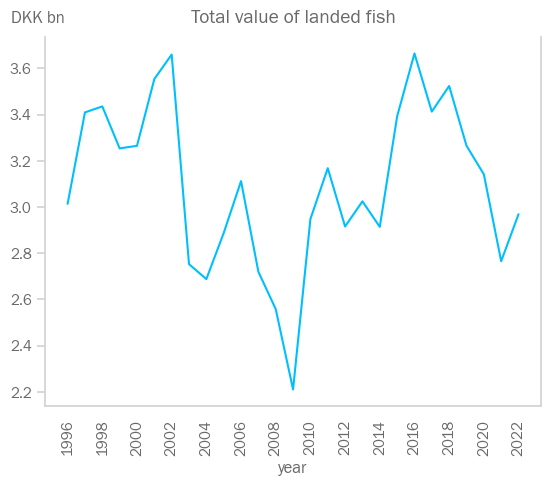

The smallest landed value was 2.21 DKKbn in 2009.
The largest landed value was 3.66 DKKbn in 2016.


In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

# Define a custom y-axis label formatter to display the units in DKK billion. This is also to remove scientific notation due to large numbers
def billions_formatter(x, pos):
    '''The two args are the value and tick position'''
    return f'{x / 1e9:.1f}'

# Set the y-axis label formatter
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(billions_formatter))

# plot total landed value
I = FISK2['fish'] == 'FISH SPECIES, TOTAL'
FISK2_total = FISK2[I].sort_values(by='year') # subsets the dataframe such that it only contains rows where I holds 
FISK2_total.reset_index(inplace = True, drop = True) # reset index and drop old index
FISK2_total.plot(x='year', y='value', kind='line', c=(0,191/255,255/255), ax=ax1) 

# plot settings
ax1.get_legend().remove() # removes legend
tick_spacing = 2 # x tick intervals
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing)) # set spacing of x ticks
plt.xticks(rotation='vertical') # rotate x ticks
ax1.set_ylabel('DKK bn', rotation=0, labelpad=25) # y label
ax1.yaxis.set_label_coords(-0.015,1.03) # placement of y label
ax1.set_title('Total value of landed fish', fontsize=14) # sets title of plot

# Show the plot
plt.show()

# Find the index of the row with the minimum and maximum value in the 'value' column
min_index = FISK2_total['value'].idxmin()
max_index = FISK2_total['value'].idxmax()

# Retrieve the 'year' and 'value' values from the row with the minimum and maximum value
min_year = FISK2_total.loc[min_index, 'year']
min_value = FISK2_total.loc[min_index, 'value']
max_year = FISK2_total.loc[max_index, 'year']
max_value = FISK2_total.loc[max_index, 'value']

# Print
print(f'The smallest landed value was {min_value/10**9:.2f} DKKbn in {min_year}.')
print(f'The largest landed value was {max_value/10**9:.2f} DKKbn in {max_year}.')

The figure shows that the yearly total value of landed fish is rather erratic. It was relatively high in the first part of the period, plunged in the years around the financial crisis and then reverted to a higher level for the rest of the period, albeit still displaying volatility.

Next, we take a look at the value of landed fish by the type of fish.

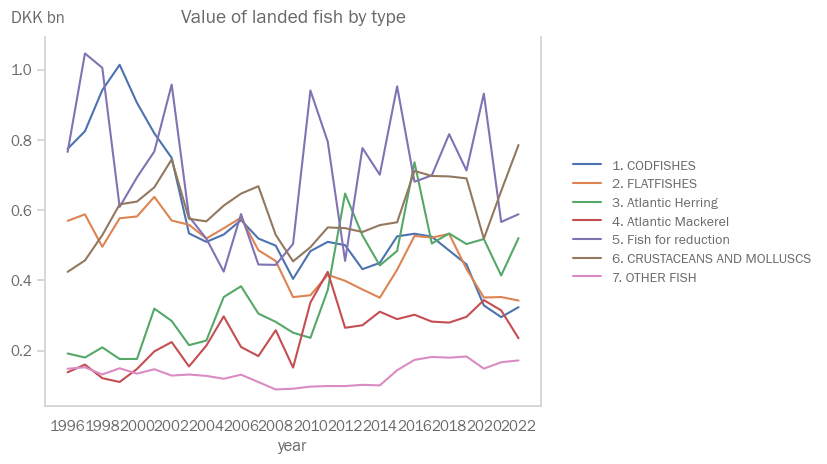

In [12]:
# list of fish categories (level 1)
fish_categories = [
    '1. CODFISHES',
    '2. FLATFISHES',
    '3. Atlantic Herring',
    '4. Atlantic Mackerel',
    '5. Fish for reduction',
    '6. CRUSTACEANS AND MOLLUSCS',
    '7. OTHER FISH']

# plot
fig = plt.figure()
ax2 = fig.add_subplot(1,1,1)

# for each category in the list of categories, plot the landed value for the period
for i in fish_categories:
    FISK2.loc[FISK2['fish'] == i].sort_values(by='year').plot(x='year', y='value', kind='line', label=i, ax=ax2)

# plot settings
ax2.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', fontsize='10', frameon=False) # places the legend to the right of the plot
tick_spacing = 2 # x tick intervals
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing)) # set spacing of x ticks
ax2.set_ylabel('DKK bn', rotation=0, labelpad=25) # y label
ax2.yaxis.set_label_coords(-0.015,1.03) # placement of y label
ax2.set_title('Value of landed fish by type', fontsize=14)
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(billions_formatter))

# Show the plot
plt.show()

The figure illustrates that the type of fish that had the largest landed value tended to be 'fish for reduction', in Danish known as *industrifisk*. However, this does not hold for all the years, e.g. in 1999, where 'codfishes' held the record, or in 2007, where it was the category 'crustaceans and molluscs'.

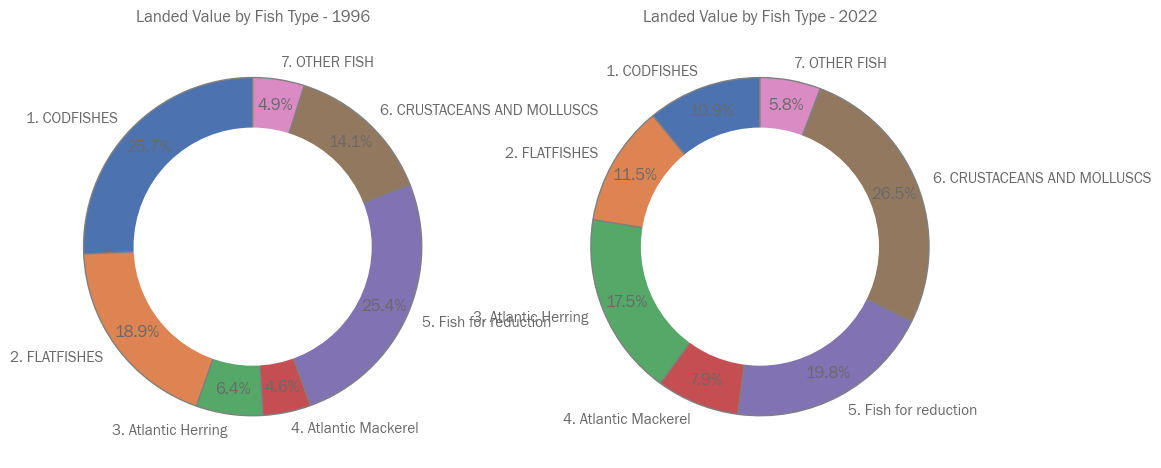

In [13]:
import matplotlib.pyplot as plt

# Filter the data for the years 1996 and 2022 and fish types in the fish_list
years = [1996, 2022]
filtered_data = FISK2[(FISK2['year'].isin(years)) & (FISK2['fish'].isin(fish_categories))]

# Group the filtered data by year and fish type and calculate the sum of values
grouped_data = filtered_data.groupby(['year', 'fish'])['value'].sum().reset_index()

# Pivot the grouped data to get fish types as columns and years as rows
pivoted_data = grouped_data.pivot(index='year', columns='fish', values='value')

# Create two pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Loop through each year and create a pie chart with a hole in the center
for i, year in enumerate(years):
    ax = axes[i]
    fish_values = pivoted_data.loc[year].values
    fish_types = pivoted_data.columns
    ax.pie(fish_values, labels=fish_types, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'gray'}, pctdistance=0.85)
    ax.set_title(f'Landed Value by Fish Type - {year}')
    ax.add_artist(plt.Circle((0,0),0.70,fc='white')) # Add a white circle to create the hole in the center

plt.show()

### Danish vessels and accidents at sea (FISK1 and SKIB95)
Now, we will look at the data on the number of Danish fishing vessels from the table FISK1.

In [14]:
tabsum = FISK1_api.tablesummary(language='en')
display(tabsum)

Table FISK1: Danish vessels by region, unit, type of vessels, length, tonnage and time
Last update: 2023-03-30T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,OMRÅDE,6,000,All Denmark,081,Region Nordjylland,False
1,TAL,3,01,Number of vessels,03,Engine power in KW,False
2,FISKFAR,6,00,Vessels total,05,Other vessels,False
3,LAENG,7,00,Vessels by length total,06,More than 40 metres,False
4,TONNAGE,5,00,Vessels bý tonnage total,04,More than 200 GT,False
5,Tid,27,1996,1996,2022,2022,True


In [15]:
for variable in tabsum['variable name']:
    print(variable+':')
    display(FISK1_api.variable_levels(variable, language='en'))

OMRÅDE:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,085,Region Sjælland
3,083,Region Syddanmark
4,082,Region Midtjylland
5,081,Region Nordjylland


TAL:


,id,text
0,01,Number of vessels
1,02,Gross tonnage
2,03,Engine power in KW


FISKFAR:


,id,text
0,00,Vessels total
1,01,Trawlers
2,02,Purse seiners and Multi-purpose vessels
3,03,Danish seiners
4,04,Liners and Gill netters
5,05,Other vessels


LAENG:


,id,text
0,00,Vessels by length total
1,01,Less than 10metres
2,02,"10-11,9 metres"
3,03,"12-17,9 metres"
4,04,"18-23,9 metres"
5,05,"24-39,9 metres"
6,06,More than 40 metres


TONNAGE:


,id,text
0,00,Vessels bý tonnage total
1,01,Less than 10 GT
2,02,"10-49,9 GT"
3,03,"50-199,9 GT"
4,04,More than 200 GT


Tid:


,id,text
0,1996,1996
1,1997,1997
2,1998,1998
3,1999,1999
4,2000,2000
5,2001,2001
6,2002,2002
7,2003,2003
8,2004,2004
9,2005,2005


In [16]:
params = FISK1_api._define_base_params(language='en')
params = {'table': 'fisk1',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'Tid', 'values': ['*']},
  {'code': 'OMRÅDE', 'values': ['000']},
  {'code': 'TAL', 'values': ['01']},
  {'code': 'FISKFAR', 'values': ['00']},
  {'code': 'LAENG', 'values': ['00']},
  {'code': 'TONNAGE', 'values': ['00']}]}

FISK1 = FISK1_api.get_data(params=params)
FISK1.head()

,TID,OMRÅDE,TAL,FISKFAR,LAENG,TONNAGE,INDHOLD
0,1996,All Denmark,Number of vessels,Vessels total,Vessels by length total,Vessels bý tonnage total,4830
1,1997,All Denmark,Number of vessels,Vessels total,Vessels by length total,Vessels bý tonnage total,4582
2,1998,All Denmark,Number of vessels,Vessels total,Vessels by length total,Vessels bý tonnage total,4373
3,1999,All Denmark,Number of vessels,Vessels total,Vessels by length total,Vessels bý tonnage total,4221
4,2000,All Denmark,Number of vessels,Vessels total,Vessels by length total,Vessels bý tonnage total,4142


In [17]:
# delete columns not to be used
try:
    del FISK1['OMRÅDE'], FISK1['TAL'], FISK1['FISKFAR'], FISK1['LAENG'], FISK1['TONNAGE']
except:
    pass

# dictionary of columnms
columns_dict = {} # intialize empty dictionary
columns_dict['TID'] = 'year'
columns_dict['INDHOLD'] = 'vessel_count'

In [18]:
# rename columns using dictionary of columns
FISK1.rename(columns=columns_dict,inplace=True)

FISK1.sort_values(by=['year'],inplace=True) # sort by year
FISK1.reset_index(inplace = True, drop = True) # reset index and drop old index
FISK1.head(10)

,year,vessel_count
0,1996,4830
1,1997,4582
2,1998,4373
3,1999,4221
4,2000,4142
5,2001,4020
6,2002,3816
7,2003,3569
8,2004,3407
9,2005,3267


Together with this dataset, we will investigate the number of accidents at sea (table SKIB95).

In [19]:
tabsum = SKIB95_api.tablesummary(language='en')
display(tabsum)

Table SKIB95: Accidents at sea involving danish vessels by type of accident, type of vessel, scope and time
Last update: 2022-05-12T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,UTYPE,12,0000,"ACCIDENTS, TOTAL",3090,Missing,False
1,SKIBTYPE,6,41110,Cargo ship,41190,Unknown,False
2,OMFANG,4,10,Marine incident,25,Very serious,False
3,Tid,8,2014,2014,2021,2021,True


In [20]:
for variable in tabsum['variable name']:
    print(variable+':')
    display(SKIB95_api.variable_levels(variable, language='en'))

UTYPE:


,id,text
0,0000,"ACCIDENTS, TOTAL"
1,3000,Capsizing
2,3010,Collision
3,3011,Fire or explosion
4,3012,Hull damage
5,3015,Touch
6,3020,Damage on vessel or equipment
7,3025,Water intrusion including shipwreck
8,3030,Grounding
9,3035,Loss of control


SKIBTYPE:


,id,text
0,41110,Cargo ship
1,41120,Passenger ship
2,41130,Fishing vessel
3,41140,Service Ship
4,41150,Inland waterway vessel
5,41190,Unknown


OMFANG:


,id,text
0,10,Marine incident
1,15,Less serious
2,20,Serious
3,25,Very serious


Tid:


,id,text
0,2014,2014
1,2015,2015
2,2016,2016
3,2017,2017
4,2018,2018
5,2019,2019
6,2020,2020
7,2021,2021


Since we are interested in fishing vessels, we only want to look at accidents relating to these. Therefore, we extract rows where the value in the column containing ship type ('SKIBTYPE') is equal to 'Fishing vessel', which has the ID code 41130 as seen above.

In [21]:
params = {'table': 'skib95',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'Tid', 'values': ['*']},
  {'code': 'UTYPE', 'values': ['0000']},
  {'code': 'SKIBTYPE', 'values': ['41130']},
  {'code': 'OMFANG', 'values': ['*']}]}

SKIB95 = SKIB95_api.get_data(params=params)
SKIB95.head()

,TID,UTYPE,SKIBTYPE,OMFANG,INDHOLD
0,2014,"ACCIDENTS, TOTAL",Fishing vessel,Very serious,3
1,2015,"ACCIDENTS, TOTAL",Fishing vessel,Serious,12
2,2017,"ACCIDENTS, TOTAL",Fishing vessel,Marine incident,1
3,2018,"ACCIDENTS, TOTAL",Fishing vessel,Serious,3
4,2019,"ACCIDENTS, TOTAL",Fishing vessel,Very serious,7


In [22]:
# delete columns not to be used
try:
    del SKIB95['UTYPE'], SKIB95['SKIBTYPE']
except:
    pass

# dictionary of columnms
columns_dict = {} # intialize empty dictionary
columns_dict['TID'] = 'year'
columns_dict['OMFANG'] = 'severity'
columns_dict['INDHOLD'] = 'accident_count'

# rename columns using dictionary of columns
SKIB95.rename(columns=columns_dict,inplace=True)

SKIB95.sort_values(by=['year','severity'],inplace=True) # sort by year, then severity
SKIB95.head()

,year,severity,accident_count
14,2014,Less serious,2
7,2014,Marine incident,1
21,2014,Serious,9
0,2014,Very serious,3
22,2015,Less serious,2


Due to the low accident counts, we are not interested in the severity. Hence, we group the observations by year, such that we get the total number of accidents per year.

In [23]:
SKIB95_total = SKIB95.groupby('year')['accident_count'].sum().reset_index() # sum count of accidents over all severities each year, and reset index
display(SKIB95_total)

,year,accident_count
0,2014,15
1,2015,19
2,2016,9
3,2017,14
4,2018,12
5,2019,16
6,2020,10
7,2021,21


It is still clear that the number of accidents per year is rather low, reaching a maximum of 21 in 2021.

Now, we merge the two dataframes `FISK1` and `SKIB95_total`. This is done using an **inner join**, such that only years contained in both dataframes are kept. Since there are fewer years in the `SKIB95_total` (2014-2021), some years from `FISK1` will be dropped (1996-2013, 2021). We could also do an **outer join**, but that would leave missing observations for one of the plots in the next figure.

In [24]:
# shapes of the two dataframes
print(f'FISK1 has shape {FISK1.shape}')
print(f'SKIB95_total has shape {SKIB95_total.shape}')

# merge
inner = pd.merge(FISK1,SKIB95_total,how='inner',on=['year']) # inner merge
display(inner) # display head of the new dataframe
print(f'The merged dataframe "inner" has shape {inner.shape}, the same as FISK1.')

FISK1 has shape (27, 2)
SKIB95_total has shape (8, 2)


,year,vessel_count,accident_count
0,2014,2455,15
1,2015,2370,19
2,2016,2273,9
3,2017,2203,14
4,2018,2135,12
5,2019,2059,16
6,2020,1998,10
7,2021,1933,21


The merged dataframe "inner" has shape (8, 3), the same as FISK1.


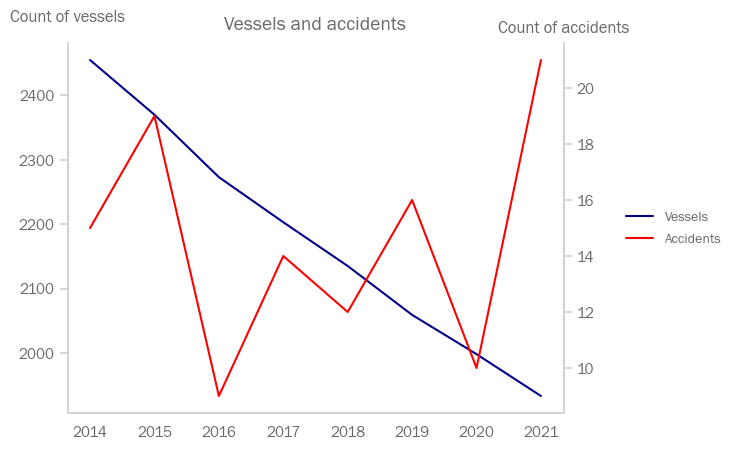

In [25]:
# plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(inner['year'],(inner['vessel_count']),c='darkblue',label='Vessels')
ax2.plot(inner['year'],(inner['accident_count']),c='red',label='Accidents')

# plot settings
ax1.legend(bbox_to_anchor=(1.1, 0.53), loc='center left', fontsize='10', frameon=False) # places the legend to the right of the plot
ax2.legend(bbox_to_anchor=(1.1, 0.47), loc='center left', fontsize='10', frameon=False) # places the legend to the right of the plot
tick_spacing = 1 # x tick intervals
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing)) # set spacing of x ticks

ax1.set_ylabel('Count of vessels', rotation=0, labelpad=25) # y label for 1st y-axis
ax1.yaxis.set_label_coords(0,1.05) # placement of y label
ax2.set_ylabel('Count of accidents', rotation=0, labelpad=25) # y label for 2nd y-axis
ax2.yaxis.set_label_coords(1,1.06) # placement of y label

ax1.set_title('Vessels and accidents', fontsize=14)

# show plot
plt.show()

The figure shows that while the number of fishing vessels has been steadily decreasing over the period, the number of accidents involving fishing vessels does not display any discernible trend. In the last year of the period, it is in fact at its highest level (21). Additionally, one may point out the few datapoints on accidents (8 years).

### Emissions (MRU1)
Lastly, we take a look at the emissions from the fishing industry. Given the decreasing number of vessels as we saw above, we would expect the emissions to have decreased in that specific period, cet. par. This reasoning only considers emissions from fishing vessels, however, not the rest of the industry's emissions (processing in warehouses, factories etc.).
A first look at the variables of the table MRU1:

In [26]:
tabsum = MRU1_api.tablesummary(language='en')
display(tabsum)

Table MRU1: Air Emission Accounts by industry, type of emission and time
Last update: 2022-10-05T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,BRANCHE,236,MTOT,Total,V970000,970000 Activities of households as employers o...,False
1,EMTYPE8,15,1,"Carbon dioxide (CO2) incl. from biomass, (1000...",15,"Hydrofluorocarbons (HFC), (tonnes CO2-equivale...",False
2,Tid,32,1990,1990,2021,2021,True


In [27]:
# The available values for each variable in the table: 
for variable in tabsum['variable name']:
    print(variable+':')
    display(MRU1_api.variable_levels(variable, language='en').head(10))

BRANCHE:


,id,text
0,MTOT,Total
1,MHUSHOLD,Households
2,MV,Total industries
3,VA,"A Agriculture, forestry and fishing"
4,V01000,01000 Agriculture and horticulture
5,V010000,010000 Agriculture and horticulture
6,V02000,02000 Forestry
7,V020000,020000 Forestry
8,V03000,03000 Fishing
9,V030000,030000 Fishing


EMTYPE8:


,id,text
0,1,"Carbon dioxide (CO2) incl. from biomass, (1000..."
1,3,"Carbon dioxide (CO2) excl. from biomass, (1000..."
2,2,"Carbon dioxide (CO2) from biomass, (1000 tonnes)"
3,4,"Sulphur dioxide (SO2), (tonnes)"
4,5,"Nitrogen oxides (NOX), (tonnes)"
5,6,"Carbon monoxide (CO), (tonnes)"
6,7,"Ammonia (NH3), (tonnes)"
7,8,"Nitrous oxide (N2O), (tonnes)"
8,9,"Methane (CH4), (tonnes)"
9,10,Non-methane volatile organic compounds (NMVOC)...


Tid:


,id,text
0,1990,1990
1,1991,1991
2,1992,1992
3,1993,1993
4,1994,1994
5,1995,1995
6,1996,1996
7,1997,1997
8,1998,1998
9,1999,1999


In [28]:
# Define base parameters
params = {'table': 'mru1',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'Tid', 'values': ['*']},
  {'code': 'BRANCHE', 'values': ['V03000']},
  {'code': 'EMTYPE8', 'values': ['*']},
  ]}

MRU1 = MRU1_api.get_data(params=params)
display(MRU1)

,TID,BRANCHE,EMTYPE8,INDHOLD
0,1990,03000 Fishing,"Carbon dioxide (CO2) incl. from biomass, (1000...",843
1,1990,03000 Fishing,Non-methane volatile organic compounds (NMVOC)...,495
2,1990,03000 Fishing,"Particulate matter < 10 µm (PM10), (tonnes)",..
3,1990,03000 Fishing,"Particulate matter < 2,5 µm (PM2,5), (tonnes)",..
4,1990,03000 Fishing,"Sulphur hexafluoride (SF6), (tonnes CO2-equiva...",..
...,...,...,...,...
475,2021,03000 Fishing,"Nitrogen oxides (NOX), (tonnes)",..
476,2021,03000 Fishing,"Carbon monoxide (CO), (tonnes)",..
477,2021,03000 Fishing,"Ammonia (NH3), (tonnes)",..
478,2021,03000 Fishing,"Nitrous oxide (N2O), (tonnes)",..


In [37]:
# delete columns not to be used
try:
    del MRU1['BRANCHE']
except:
    pass

# dictionary of columnms
columns_dict = {} # intialize empty dictionary
columns_dict['TID'] = 'year'
columns_dict['EMTYPE8'] = 'emission_type'
columns_dict['INDHOLD'] = 'emissions'

# rename columns using dictionary of columns
MRU1.rename(columns=columns_dict,inplace=True)
MRU1.reset_index(inplace = True, drop = True) # reset index and drop old index
MRU1.sort_values(by=['year','emission_type'],inplace=True) # sort by year, then by emission type.
MRU1.head(10)

,year,emission_type,emissions
0,1990,"Ammonia (NH3), (tonnes)",0
1,1990,"Carbon dioxide (CO2) excl. from biomass, (1000...",844
2,1990,"Carbon dioxide (CO2) from biomass, (1000 tonnes)",0
3,1990,"Carbon dioxide (CO2) incl. from biomass, (1000...",843
4,1990,"Carbon monoxide (CO), (tonnes)",1804
5,1990,"Hydrofluorocarbons (HFC), (tonnes CO2-equivale...",..
6,1990,"Methane (CH4), (tonnes)",23
7,1990,"Nitrogen oxides (NOX), (tonnes)",7066
8,1990,"Nitrous oxide (N2O), (tonnes)",17
9,1990,Non-methane volatile organic compounds (NMVOC)...,495


As some values in the emissions column are strings they are converted to integers.

In [43]:
MRU1['emissions'].replace("..", "",inplace=True)
display(MRU1)

,year,emission_type,emissions
0,1990,"Ammonia (NH3), (tonnes)",0
1,1990,"Carbon dioxide (CO2) excl. from biomass, (1000...",844
2,1990,"Carbon dioxide (CO2) from biomass, (1000 tonnes)",0
3,1990,"Carbon dioxide (CO2) incl. from biomass, (1000...",843
4,1990,"Carbon monoxide (CO), (tonnes)",1804
...,...,...,...
475,2021,"Particulate matter < 10 µm (PM10), (tonnes)",
476,2021,"Particulate matter < 2,5 µm (PM2,5), (tonnes)",
477,2021,"Perfluorocarbons (PFC), (tonnes CO2-equivalents)",
478,2021,"Sulphur dioxide (SO2), (tonnes)",


To illustrate the development of the emissions by the fishing industry, an interactive plot is created. You can use the dropdown to change the emission type!

In [46]:
# show gridlines in plot
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})

# define interactive plot
def interactive_plot(emission_type):
    plt.figure(figsize=(10, 6))
    plt.title(f'Emissions of {emission_type}, 1990-2021')
    plt.ylabel('Emissions')
    emissions_data = MRU1[MRU1['emission_type'] == emission_type].sort_values(by='year')
    plt.plot(emissions_data['year'], emissions_data['emissions'])
    plt.autoscale(enable=True, axis='y') 
    plt.show()

# Get the unique emission types
emission_types = MRU1['emission_type'].unique()

# Create a dropdown widget for selecting emission type. Here, the ipywidgets package is used.
emission_type_dropdown = widgets.Dropdown(
    options=emission_types,
    description='Emission Type:',
    value=emission_types[0], # default value of the dropdown
    style={'description_width': 'initial'} # makes space for the dropdown so that the text is correctly displayed
)

# Use the interact function to update the plot with the selected emission type
interact(interactive_plot, emission_type=emission_type_dropdown)

interactive(children=(Dropdown(description='Emission Type:', options=('Ammonia (NH3), (tonnes)', 'Carbon dioxi…

<function __main__.interactive_plot(emission_type)>